This model is from Jan 2022. It contains important improvements over previous models, namely:

- it doesn't need particles any more
    - (but still uses them in order to evaluate and visualize certain functions)
- instead, the lower *mesh boundaries* are now identical with the underlying topography
- the output routine has been vastly improved and is much more flexible now.

# Basic python imports and model settings

In [36]:
import underworld.visualisation as vis
from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]

# make it command line compatible

# make it command line compatible
if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 0

i = km_index

systemDim = L[i] 

maxX = L[i] * 1000.
min_bed_height = 500.           # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = 500.
average_bedthickness = 1000.
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height
maxZ = maxX

minY = minX = minZ = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

resX = 50
resY = 15
resZ = 8

print("resX: " + str(resX) + " resY: " + str(resY) )

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "_res_" + str(resX) + "_x_" + str(resY) + "_x_" + str(resZ) + "/")

if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)
    
delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?

cell_height = maxY / resY
cell_width = maxX / resX
cell_depth = maxZ / resZ

resX: 50 resY: 15


# The mesh

In [37]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY, resZ),
                                minCoord=(minX, minY, minZ),
                                maxCoord=(maxX, maxY, maxZ),
                                periodic=[True, False, True])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
#pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(nodeDofCount=1)

#pressureField.data[:] = 0.
velocityField.data[:] = [0., 0., 0.]

	Global element size: 50x15x8
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 50x15x8


# topo-function

In [38]:
coord = fn.input()
z_bed_function = surface_height - average_bedthickness + amplitude * fn.math.sin(omega * coord[0]) # * fn.math.sin(omega * coord[2])

# Deform mesh - lower boundary

In [39]:
dx = (maxX - minX) / resX
dy = (maxX - maxY) / resY
dz = (maxZ - minZ) / resZ

def mesh_deform_Ind(section, fixPoint_index, fixPoint, mi):
    
    section[fixPoint_index] = fixPoint
    seqN = len(section)
        
    # fixPoint_index (int): specify the index of the section to be at the place need to be refined
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    
    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  index < fixPoint_index:
            
            section[index] = minCoord + index * (fixPoint-minCoord) / fixPoint_index            
            zz_pow = (fixPoint - section[index])**mi
            zz_pow_max = (fixPoint - minCoord)**mi
            section[index] = fixPoint - (fixPoint-section[index]) * zz_pow / zz_pow_max

        if  index > fixPoint_index:
            
            section[index] = fixPoint + (index-fixPoint_index)*(maxCoord-fixPoint) / (seqN-fixPoint_index-1)
            zz_pow = (section[index] - fixPoint)**mi
            zz_pow_max = (maxCoord - fixPoint)**mi
            section[index] =fixPoint + (section[index]-fixPoint) * zz_pow / zz_pow_max    
            
    return (section)

with mesh.deform_mesh():

    base = []
    
    for indexx in range(resX + 1):

        for indexz in range(resZ + 1):

            start_x = dx * indexx
            start_z = dz * indexz

            interface_y = z_bed_function.evaluate((start_x, 0., start_z))[0][0]

            ind = np.where( np.logical_and( abs(mesh.data[:, 0] - start_x) < 0.01*dx , 
                           abs(mesh.data[:, 2] - start_z) < 0.01*dz ) )
            
            mesh.data[ind[0],1] = mesh_deform_Ind(mesh.data[ind[0], 1], int(0), interface_y, 0.2)

            base.append( ind[0][ np.argmin( abs( mesh.data[ind, 1] - interface_y )[0] ) ] )  

swarmCustom = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
result = swarmCustom.add_particles_with_coordinates(mesh.data[base])


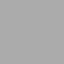

{}

In [40]:
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh))
figMesh.window()

# A dummy swarm
for evaluation

In [41]:
part_per_cell = 500
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# Initialise the 'materialVariable' data to represent different materials.
materialV = 0  	# ice, isotropic
materialR = 1   # rock

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
#swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm, velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm, velocityField=velocityField, order=2)

# Boundary conditions

In [42]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]

# Surface points
topSet = mesh.specialSets["MaxJ_VertexSet"]

leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']
botSet = mesh.specialSets["MinJ_VertexSet"]

# Dirichlet
condition = uw.conditions.DirichletCondition(variable = velocityField, indexSetsPerDof=(botSet, botSet, botSet))

velocityField.data[:] = [0., 0., 0.]

In [43]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

# Viscosity, density, buoyancy

In [44]:
minViscosityIceFn = fn.misc.constant(1e+8 / 31556926)
maxViscosityIceFn = fn.misc.constant(1e+16 / 31556926)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFn = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFn = fn.misc.constant( ice_density )

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment C/D, 0.5 = Experiment A/B
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination), 0.)

buoyancyFn = densityFn * z_hat * 9.81

In [45]:
devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

# Solver

In [46]:
stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=condition,
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
solver.set_inner_method("mumps")
#solver.set_inner_method("superludist")
#solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e21 / 31556926)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3
#penalty = 1e3
#solver.set_penalty(penalty)
#nl_tol = 2.e1
nl_tol = 1.e-2

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=topSet)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topSet)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    exec_time = time.time()
    #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
   
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    exec_time = time.time() - exec_time

    # print full stats to a file
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)
    
print (f'Solving took: {exec_time} seconds')

In func WeightsCalculator_CalculateAll(): for swarm "Y5Y5FR4N__swarm"
	done 33% (2000 cells)...
	done 67% (4000 cells)...
	done 100% (6000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "Y5Y5FR4N__swarm"
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Calibration pressure 8595.571512035507Linear solver (JV0ZEIH2__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.04197 secs / 1 its
  Pressure Solve:         = 0.3807 secs / 13 its
  Final V Solve:          = 0.0222 secs / 1 its

  Total BSSCR Linear solve time: 1.737565 seconds

Linear solver (JV0ZEIH2__system-execute), solution time 1.743516e+00 (secs)

Calibration pressure -31570.563450081783
Non linear solver - iteration 1
Linear solver (JV0ZEIH2__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solve

In func SystemLinearEquations_NonLinearExecute: Iteration 10 of 500 - Residual 0.051756 - Tolerance = 0.01
Calibration pressure -114087.34102786925
Non linear solver - Residual 5.17558540e-02; Tolerance 1.0000e-02 - Not converged - 1.758479e+02 (secs)

Non linear solver - iteration 11
Linear solver (JV0ZEIH2__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 0.04001 secs / 1 its
  Pressure Solve:         = 0.4198 secs / 14 its
  Final V Solve:          = 0.02364 secs / 1 its

  Total BSSCR Linear solve time: 1.601924 seconds

Linear solver (JV0ZEIH2__system-execute), solution time 1.607787e+00 (secs)
In func SystemLinearEquations_NonLinearExecute: Iteration 11 of 500 - Residual 0.034817 - Tolerance = 0.01
Non linear solver - Residual 3.48170147e-02; Tolerance 1.0000e-02 - Not converged - 1.924057e+02 (secs)

Non linear solver - ite


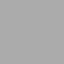

{}

In [12]:
figStress = vis.Figure(figsize=(1200,600))
figStress.append( vis.objects.Mesh(mesh))
figStress.append(vis.objects.Points(swarm, shearStressFn, pointSize=4.0, colourBar=True, ))#fn_mask = materialVariable))
figStress.window()

# Output

/home/jovyan/workspace/ExpB-18.1.22-new-sys-boundaries-new-output/output_5000.0_res_12_x_12_x_8/output_160000.0_res_12_x_12_x_8/output_160000.0_res_50_x_15_x_8/jla1c160.csv
DeltaP


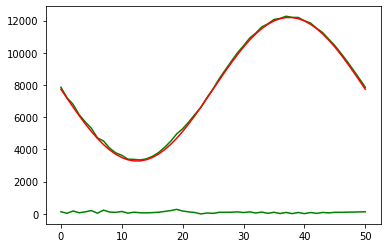

vs


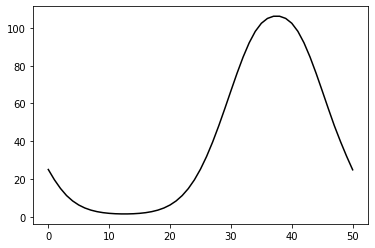

Shear stress


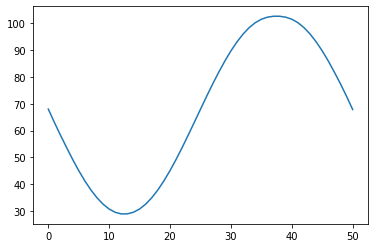

In [50]:
#### Filename
outputFile = os.path.join(os.path.abspath("."), "jla"+"1c"+ str(systemDim).zfill(3) + ".csv")
print(outputFile)

#### Smooth the stress
meshStressTensor = uw.mesh.MeshVariable(mesh, 6)
projectorStress = uw.utils.MeshVariable_Projection( meshStressTensor, devStressFn, type=0 )
projectorStress.solve()

#### Smooth the velocity
meshVelocity = uw.mesh.MeshVariable(mesh, 3)
projectorV = uw.utils.MeshVariable_Projection( meshVelocity, velocityField, type=0 )
projectorV.solve()

#### Smooth the pressure
meshP = uw.mesh.MeshVariable(mesh, 1)
projectorP = uw.utils.MeshVariable_Projection( meshP, pressureField, type=0 )
projectorP.solve()

#### Points
xpos = np.arange(start=0, stop=int(resX+1)) * maxX / resX
zpos = np.arange(start=0, stop=int(resZ+1)) * maxZ / resZ

xz = np.array(np.meshgrid(xpos, zpos)).T.reshape(-1,2)

sub = 1. * cell_height
add = 1. * cell_height

surf_pos = np.insert(xz, 1, maxY - sub, axis=1 )
base_pos = np.insert(xz, 1, 0., axis=1 )

surf_y = z_bed_function.evaluate(xz)
base_pos[:, 1] = surf_y[:,0] + add

#### Get the surface velocity
vxs = meshVelocity.evaluate(surf_pos).transpose()[0]
vys = meshVelocity.evaluate(surf_pos).transpose()[1]
vzs = meshVelocity.evaluate(surf_pos).transpose()[2]

vtots = np.sqrt( vxs*vxs + vys*vys + vzs*vzs )

#### Get the basal velocity
vxb = meshVelocity.evaluate(base_pos).transpose()[0]
vyb = meshVelocity.evaluate(base_pos).transpose()[1]
vzb = meshVelocity.evaluate(base_pos).transpose()[2]

vtotb = np.sqrt( vxb*vxb + vyb*vyb + vzb*vzb )

#### Get the pressure
P = meshP.evaluate(base_pos).squeeze()
#P = pressureField.evaluate(base_pos).squeeze()

#### Get the shearstress
sxz = meshStressTensor.evaluate(base_pos).squeeze()[:,3]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

sxy = meshStressTensor.evaluate(base_pos).squeeze()[:,4]
#sxz = devStressFn.evaluate(base_pos).squeeze()[:,3]

#### only indices where z ~ 0.25
ind = np.where(np.logical_and(xz[:,1] > 0.22 * maxZ , xz[:,1] < 0.28 * maxZ))

#### plot pressure from grid / theoretical / difference
print("DeltaP")
#pyplot.plot((maxY - base_ypos[:]) * 9.81 * 910, color='red')
smoothed_2dg = savgol_filter(P[ind], window_length = 7, polyorder = 2)
#pyplot.plot(P[ind], color='blue')

pyplot.plot((P[ind]  - (maxY - base_pos[ind, 1].squeeze()) * 9.81 * 910.) / 1000. , color='green')
pyplot.plot((P[ind]) / 1000. , color='green')
pyplot.plot(((maxY - base_pos[ind, 1].squeeze()) * 9.81 * 910.) / 1000. , color='red')
pyplot.show()

#### plot vx at surface
print("vs")
smoothed_2dg = savgol_filter(vxs[ind], window_length = 7, polyorder = 2)
#pyplot.plot(vxs[ind], color='red')
pyplot.plot(smoothed_2dg, color='black')
pyplot.show()

### plot shear stress
print("Shear stress")
smoothed_2dg = savgol_filter(sxz[ind] / 1000, window_length = 7, polyorder = 2)
pyplot.plot(smoothed_2dg)
pyplot.show()

#### output to file
with open(outputFile, "w") as text_file:
    
    for i in ind[0]:
        
        # Ausgabe [x] [y]
        textline = str("{:.7f}".format(surf_pos[i, 0] / maxX)) + "\t" \
        + str("{:.7f}".format(surf_pos[i, 2] / maxZ)) + "\t"
        
        #Ausgabe Geschwindigkeiten Surface[vx] [vy] [vz]
        textline += str("{:.7f}".format(vxs[i])) + "\t" + str("{:.7f}".format(vzs[i])) \
        + "\t" + str("{:.7f}".format(vys[i])) + "\t"
        
        #Ausgabe Geschwindigkeiten Basis [vx] [vy]
        textline += str("{:.7f}".format(vxb[i])) + "\t" + str("{:.7f}".format(vzb[i])) + "\t"
        
        # Scherspannung Basis Tensoren [Txz] [Tyz]
        textline += str("{:.7f}".format(sxz[i] / 1000.)) + "\t" + str("{:.7f}".format(sxy[i] / 1000.)) + "\t"
        
        # Ausgabe delta p
        textline += str("{:.7f}".format( (P[i] - float((maxY - base_pos[i, 1]) * 9.81 * 910 )) / 1000)) + "\n"
        
        text_file.write(textline)
        #print(textline)